
# Week 6 — scRNA‑seq mini‑pipeline (Alevin‑fry → AnnData → Leiden → CellTypist)

Goal: Fetch raw single‑cell FASTQs, build a compact splici reference, quantify with the alevin‑fry (via simpleaf) pipeline, load counts into an AnnData, cluster with Leiden, then auto‑annotate with CellTypist.  
This notebook is designed to be self‑contained to the best that I could make it: it installs its own tools and fetches data at run time. The only things that i downloaded manuallly and setup were the data files needed for the assignment. I tried to get it to automatically fetch the files but I was haing alot of trouble with it.



## 0) Configuration & small helpers

In the following cells I set up project directories and define helper functions and constants.

In [64]:

import os, sys, json, subprocess, shutil, textwrap, time, pathlib

# Project directories
ROOT = pathlib.Path.cwd()
DATA = ROOT / "week6_data"
WORK = ROOT / "week6_work"
OUT  = ROOT / "week6_results"
for d in (DATA, WORK, OUT):
    d.mkdir(parents=True, exist_ok=True)

BOX_FOLDER_URL = "https://app.box.com/s/lx2xownlrhz3us8496tyu9c4dgade814"
BOX_EXPECTED = {}

PERMIT_STRATEGY = str((ROOT / "3M-february-2018.txt.gz").resolve())
CHEMISTRY = "10xv3"
THREADS = 8

def sh(cmd, env=None, check=True):
    print(f"\n$ {cmd}")
    proc = subprocess.run(cmd, shell=True, env=env, check=check)
    return proc.returncode

print("ROOT:", ROOT)
print("DATA:", DATA)
print("WORK:", WORK)
print("OUT:", OUT)


# Cell 0 — reproducibility
import os, random, numpy as np, scanpy as sc
SEED = 42  # pick any fixed integer

# Make randomness deterministic across libs
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

random.seed(SEED)
np.random.seed(SEED)

ROOT: /home/biouser/fall25-csc-bioinf/week6
DATA: /home/biouser/fall25-csc-bioinf/week6/week6_data
WORK: /home/biouser/fall25-csc-bioinf/week6/week6_work
OUT: /home/biouser/fall25-csc-bioinf/week6/week6_results


In [65]:
# Patch: define mmrun and ensure ALEVIN_FRY_HOME for the current kernel/env
import os, subprocess, pathlib

AF_HOME = (WORK / "af_home")
AF_HOME.mkdir(parents=True, exist_ok=True)
os.environ["ALEVIN_FRY_HOME"] = str(AF_HOME)

def mmrun(cmd: str):
    print(f"$ {cmd}")
    return subprocess.run(cmd, shell=True, check=True).returncode

In [66]:
# Initialize simpleaf path config (creates $ALEVIN_FRY_HOME/simpleaf_info.json)
mmrun(f"export ALEVIN_FRY_HOME={AF_HOME}; simpleaf set-paths")

$ export ALEVIN_FRY_HOME=/home/biouser/fall25-csc-bioinf/week6/week6_work/af_home; simpleaf set-paths
found `piscem` in the PATH at /home/biouser/micromamba/envs/scweek6/bin/piscem
found `salmon` in the PATH at /home/biouser/micromamba/envs/scweek6/bin/salmon
found `alevin-fry` in the PATH at /home/biouser/micromamba/envs/scweek6/bin/alevin-fry
2025-11-12T02:16:34.412705Z  INFO simpleaf::utils::prog_utils: Could not find macs3 executable, peak calling cannot be peformed by simpleaf


0


## 1) Build a splici reference index (for USA mode)

Building a spliced + intronic (splici) reference from the provided genome FASTA and GTF, then making a compact piscem index via simpleaf index.


In [67]:

import glob

def find_one(patterns):
    for p in patterns:
        m = glob.glob(str(DATA / p))
        if m:
            return m[0]
    return None

GENOME = find_one(["*.fa", "*.fa.gz", "*chr5*.fa*", "**/*.fa*", "**/*chr5*.fa*"])
GTF    = find_one(["*.gtf", "*.gtf.gz", "**/*.gtf*", "**/*chr5*.gtf*"])
print("GENOME:", GENOME)
print("GTF:", GTF)
assert GENOME and GTF, "Could not find genome FASTA or GTF in week6_data."

IDX_DIR = WORK / "splici_index"
IDX_DIR.mkdir(parents=True, exist_ok=True)

mmrun(f"export ALEVIN_FRY_HOME={str(AF_HOME)}; ulimit -n 2048; simpleaf index --output {str(IDX_DIR)} --fasta {GENOME} --gtf {GTF} --threads {THREADS}")
print("Index ready:", IDX_DIR)


GENOME: /home/biouser/fall25-csc-bioinf/week6/week6_data/genome.fa
GTF: /home/biouser/fall25-csc-bioinf/week6/week6_data/genes.gtf
$ export ALEVIN_FRY_HOME=/home/biouser/fall25-csc-bioinf/week6/week6_work/af_home; ulimit -n 2048; simpleaf index --output /home/biouser/fall25-csc-bioinf/week6/week6_work/splici_index --fasta /home/biouser/fall25-csc-bioinf/week6/week6_data/genome.fa --gtf /home/biouser/fall25-csc-bioinf/week6/week6_data/genes.gtf --threads 8
2025-11-12T02:16:34.570459Z  INFO simpleaf::utils::af_utils: The directory /home/biouser/fall25-csc-bioinf/week6/week6_work/splici_index/ref doesn't yet exist; attempting to create it.
2025-11-12T02:16:34.571019Z  INFO simpleaf::simpleaf_commands::indexing: preparing to make reference with roers
2025-11-12T02:16:34.578146Z  INFO grangers::reader::gtf: Finished parsing the input file. Found 3 comments and 2439 records.
2025-11-12T02:16:34.583918Z  INFO roers: Built the Grangers object for 2439 records
2025-11-12T02:16:34.630792Z  WARN 


## 2) Quantify FASTQs with simpleaf quant

This step scans week6_data/ for *_R1_* and *_R2_* FASTQs (recursively), then runs simpleaf quant in cr‑like resolution and USA mode.  
If there is no explicit whitelist, set no variable (auto) or use SC_PERMIT=expect:N.


In [68]:

import subprocess, os

# Discover FASTQs
reads1 = subprocess.check_output(
    ["bash","-lc", f"find -L {DATA} -type f -name '*_R1_*fastq*' -o -name '*R1*fastq*' | sort | paste -sd, -"]
).decode().strip()
reads2 = subprocess.check_output(
    ["bash","-lc", f"find -L {DATA} -type f -name '*_R2_*fastq*' -o -name '*R2*fastq*' | sort | paste -sd, -"]
).decode().strip()
print("R1 files:", reads1)
print("R2 files:", reads2)
assert reads1 and reads2, "No FASTQs found under week6_data."

QUANT_DIR = WORK / "af_quant_run"
QUANT_DIR.mkdir(parents=True, exist_ok=True)

# Use your 10x v3 whitelist as an explicit permit list
PERMIT_FILE = str((ROOT / "week6_data/3M-february-2018.txt").resolve())
permit_flag = f"--explicit-pl {PERMIT_FILE}"

cmd = f"""
export ALEVIN_FRY_HOME={str(AF_HOME)}
ulimit -n 2048
simpleaf quant \
  --reads1 {reads1} \
  --reads2 {reads2} \
  --threads {THREADS} \
  --index {str(IDX_DIR)}/index \
  --chemistry {CHEMISTRY} --resolution cr-like \
  {permit_flag} --anndata-out \
  --output {str(QUANT_DIR)}
"""
mmrun(cmd)
print("Quantification done ->", QUANT_DIR)


R1 files: /home/biouser/fall25-csc-bioinf/week6/week6_data/selected_R1_reads.fastq
R2 files: /home/biouser/fall25-csc-bioinf/week6/week6_data/selected_R2_reads.fastq
$ 
export ALEVIN_FRY_HOME=/home/biouser/fall25-csc-bioinf/week6/week6_work/af_home
ulimit -n 2048
simpleaf quant   --reads1 /home/biouser/fall25-csc-bioinf/week6/week6_data/selected_R1_reads.fastq   --reads2 /home/biouser/fall25-csc-bioinf/week6/week6_data/selected_R2_reads.fastq   --threads 8   --index /home/biouser/fall25-csc-bioinf/week6/week6_work/splici_index/index   --chemistry 10xv3 --resolution cr-like   --explicit-pl /home/biouser/fall25-csc-bioinf/week6/week6_data/3M-february-2018.txt --anndata-out   --output /home/biouser/fall25-csc-bioinf/week6/week6_work/af_quant_run

2025-11-12T02:16:41.764474Z  INFO simpleaf::simpleaf_commands::quant: found local t2g file at /home/biouser/fall25-csc-bioinf/week6/week6_work/splici_index/index/t2g_3col.tsv, will attempt to use this since none was provided explicitly
2025-11-12

## 3) Load counts into AnnData and do basic QC/normalization

In this cell I process the simpleaf-produced H5AD file for QC, filtering, normalization, dimensionality reduction, clustering, and saveing an intermediate file for later annotation.

In [73]:

import scanpy as sc, anndata as ad, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# Useing the simpleaf-produced H5AD (no extra "alevin" in the path)
H5AD = QUANT_DIR / "af_quant" / "alevin" / "quants.h5ad"
assert H5AD.exists(), f"Missing {H5AD} — check the quant step logs."

adata = sc.read_h5ad(H5AD)
adata.var_names_make_unique()

# Gene symbols (if available)
adata.var["symbol"] = adata.var["feature_name"] if "feature_name" in adata.var.columns else adata.var_names

# Prefering spliced counts for clustering if present
if hasattr(adata, "layers") and "spliced" in adata.layers:
    adata.X = adata.layers["spliced"].copy()

# QC metrics
adata.var["mt"] = adata.var["symbol"].str.upper().str.startswith(("MT-","MT_"))
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

print("BEFORE filter -> cells, genes:", adata.shape)
print(adata.obs[["total_counts","n_genes_by_counts","pct_counts_mt"]].describe().round(2))

# Lenient filters for tiny demo data
sc.pp.filter_cells(adata, min_counts=1) # keep cells with >=1 count
sc.pp.filter_genes(adata, min_cells=1)  # keep genes seen in >=1 cell
# (Skip mt% filter; it's 0 anyway and can drop cells unnecessarily.)

# Guard: if still empty, bail with a message
if adata.n_obs == 0 or adata.n_vars == 0:
    raise ValueError(f"After lenient filters, empty matrix: {adata.shape}. "
                     "Lower thresholds further or re-run quant with --expect-cells.")

# Normalize & log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVGs / Scale / PCA — adapt to size
n_top = int(min(adata.n_vars, 500))
sc.pp.highly_variable_genes(adata, n_top_genes=n_top, subset=True)
if adata.n_vars > 1:
    sc.pp.scale(adata, max_value=10)

n_pcs = max(2, min(10, adata.n_vars - 1, adata.n_obs - 1))
sc.tl.pca(adata, n_comps=n_pcs, svd_solver="arpack")

n_neighbors = max(2, min(10, adata.n_obs - 1))
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=SEED)

# UMAP may fail on ultra-tiny data; fall back to first 2 PCs
try:
    sc.tl.umap(adata, min_dist=0.3, random_state=SEED)
except Exception:
    adata.obsm["X_umap"] = adata.obsm["X_pca"][:, :2]

sc.tl.leiden(adata, key_added="leiden_0p5", resolution=0.5, random_state=SEED)

# Saveing intermediate
OUT.mkdir(parents=True, exist_ok=True)
adata.write(OUT / "week6_preannot.h5ad", compression="gzip")

print("AFTER filter -> cells, genes:", adata.shape)
print("Clusters (leiden_0p5):")
print(adata.obs["leiden_0p5"].value_counts().sort_index())
adata



BEFORE filter -> cells, genes: (935, 20)
       total_counts  n_genes_by_counts  pct_counts_mt
count        935.00             935.00          631.0
mean           5.17               2.08            0.0
std           14.84               3.91            0.0
min            0.00               0.00            0.0
25%            0.00               0.00            0.0
50%            1.00               1.00            0.0
75%            1.00               1.00            0.0
max          134.00              19.00            0.0


/home/biouser/micromamba/envs/scweek6/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


AFTER filter -> cells, genes: (631, 19)
Clusters (leiden_0p5):
leiden_0p5
0     140
1      88
2      47
3      44
4      34
5      32
6      32
7      27
8      26
9      25
10     24
11     23
12     22
13     21
14     17
15     15
16     14
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 631 × 19
    obs: 'barcodes', 'corrected_reads', 'mapped_reads', 'deduplicated_reads', 'mapping_rate', 'dedup_rate', 'mean_by_max', 'num_genes_expressed', 'num_genes_over_mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_0p5'
    var: 'gene_id', 'gene_symbol', 'symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'collate_info', 'gpl_info', 'quant_info', 'simpleaf_map_info', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_0p5'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## 4) Clustering plot (UMAP colored by Leiden)

In this cell I plot UMAPs colored by leiden clusters and QC metrics. Using scanpy.

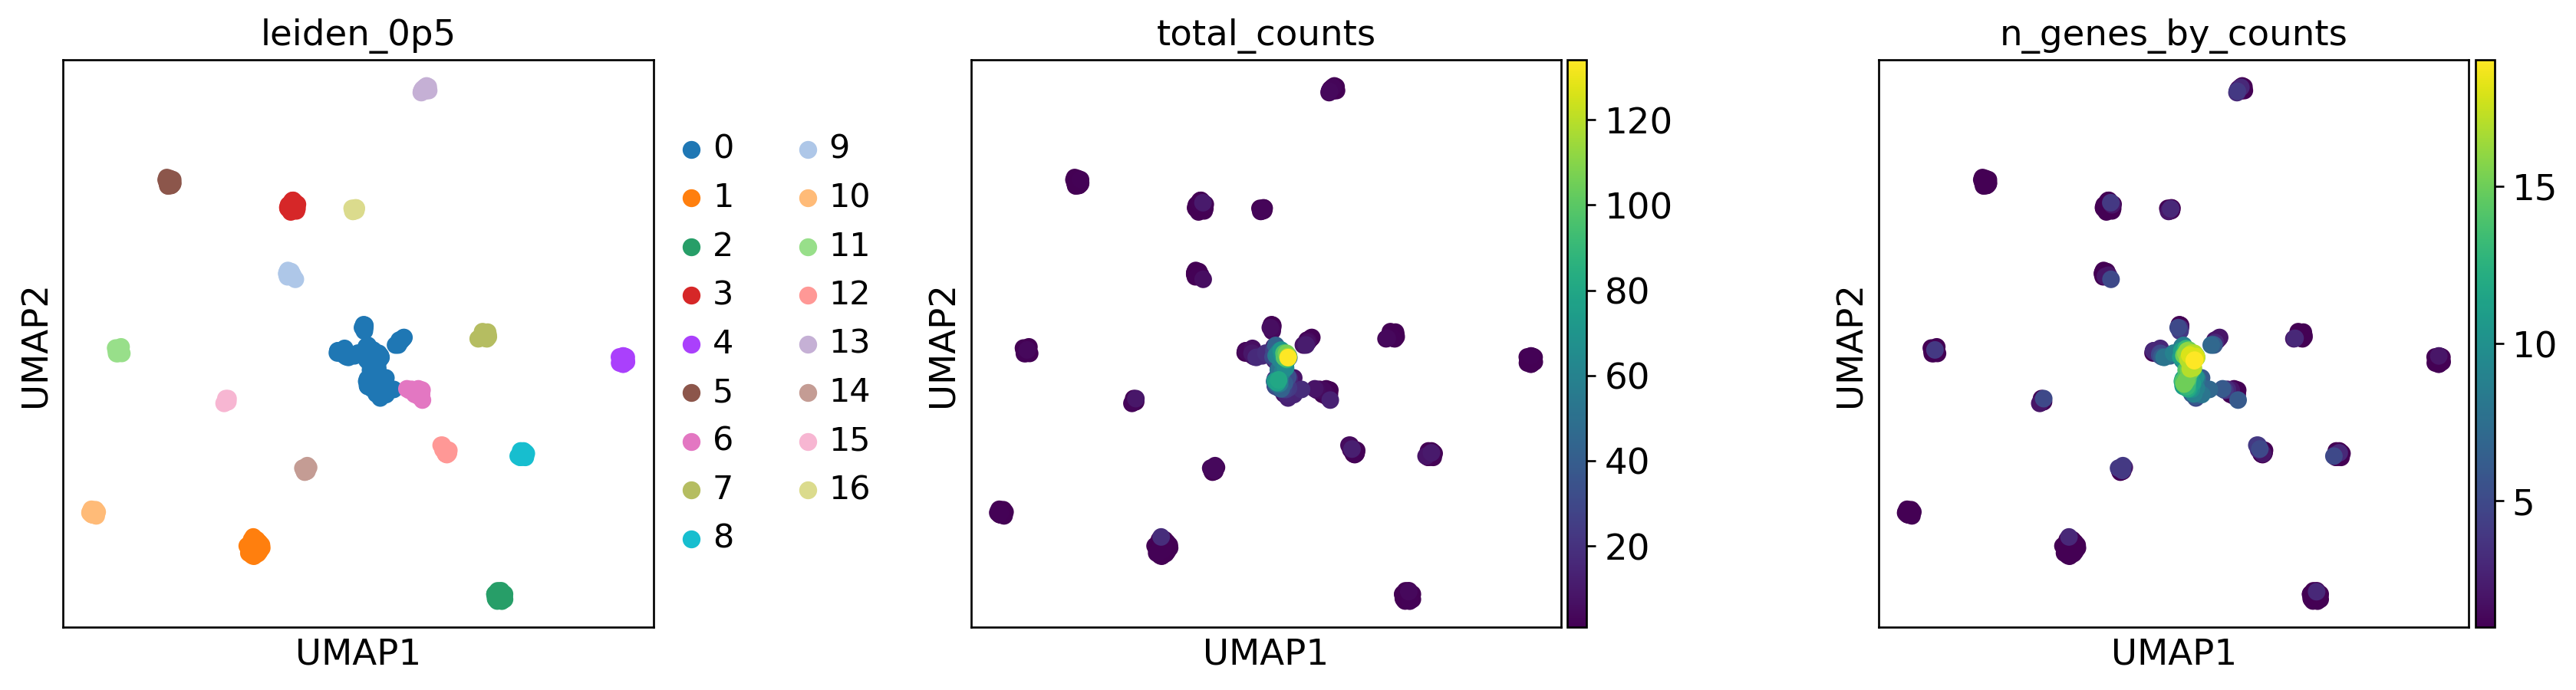

In [74]:
import matplotlib.pyplot as plt
import scanpy as sc

sc.set_figure_params(dpi=120)
ax = sc.pl.umap(
    adata,
    color=["leiden_0p5","total_counts","n_genes_by_counts"],
    wspace=0.4,
    show=False,
)
plt.savefig(OUT / "week6_umap_leiden.png", bbox_inches="tight")
plt.show()



## 5 a) Automatic cell annotation with CellTypist

Downloading a CellTypist model and annotate cells; labels are added to `adata.obs` and plotted on UMAP.

In this cell I also run CellTypist to annotate cell types and store the results in adata.obs['celltypist_label'].

In [75]:
# Cell 7 

import scanpy as sc, matplotlib.pyplot as plt, pandas as pd
import celltypist
from celltypist import models
from pathlib import Path

# Ensure models exist 
try:
    models.download_models(model='Immune_All_Low')
except Exception:
    models.download_models()

# Picking a model by absolute path 
model_dir = Path.home() / ".celltypist" / "data" / "models"
for name in ["Immune_All_Low", "Immune_All_High", "Healthy_COVID19_PBMC", "COVID19_Immune_Landscape"]:
    p = model_dir / f"{name}.pkl"
    if p.exists():
        model_path, model_name = p, name
        break
else:
    pkls = sorted(model_dir.glob("*.pkl"))
    assert pkls, f"No CellTypist models found in {model_dir}"
    model_path, model_name = pkls[0], pkls[0].stem

print("Using model:", model_name, "->", model_path)
model = models.Model.load(model=str(model_path))

# Build a CT-ready AnnData from raw counts 
adata_ct = adata.raw.to_adata() if adata.raw is not None else adata.copy()
if "spliced" in adata_ct.layers:
    adata_ct.X = adata_ct.layers["spliced"].copy()

# Normalize + log1p for CellTypist
sc.pp.normalize_total(adata_ct, target_sum=1e4)
sc.pp.log1p(adata_ct)

# Make sure var_names are gene symbols for matching
if "gene_symbol" in adata_ct.var.columns:
    adata_ct.var_names = adata_ct.var["gene_symbol"].astype(str)
elif "feature_name" in adata_ct.var.columns:
    adata_ct.var_names = adata_ct.var["feature_name"].astype(str)
adata_ct.var_names_make_unique()

# Running CellTypist 
pred = celltypist.annotate(adata_ct, model=model, majority_voting=True)

# Running a clean, align, and store labels as categorical strings 
import numpy as np
import pandas as pd

# Trying a few attribute names / structures CellTypist uses across versions
raw = getattr(pred, "predicted_labels", None)
if raw is None:
    # some versions stash labels under majority_voting
    mv = getattr(pred, "majority_voting", None)
    if mv is not None:
        raw = getattr(mv, "predicted_labels", mv)

assert raw is not None, "Could not find predicted labels in CellTypist result."

# Normalize to a 1D array/Series
if isinstance(raw, pd.DataFrame):
    raw = raw.iloc[:, 0] # first column
if isinstance(raw, pd.Series):
    lab1d = raw.to_numpy()
else:
    lab1d = np.asarray(raw).ravel() # handles (n,1) -> (n,)

# Building aligned Series against adata_ct’s cell order
labels = pd.Series(lab1d, index=adata_ct.obs_names, name="celltypist_label")
labels = labels.astype(str).replace({"None": "Unknown", "nan": "Unknown"})

# Reindex to main adata and store as categorical
labels = labels.reindex(adata.obs_names).fillna("Unknown")
adata.obs["celltypist_label"] = pd.Categorical(labels)


📂 Storing models in /home/biouser/.celltypist/data/models
📂 Storing models in /home/biouser/.celltypist/data/models
⏩ Skipping [1/58]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/58]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/58]: Adult_COVID19_PBMC.pkl (file exists)
⏩ Skipping [4/58]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [5/58]: Adult_Human_MTG.pkl (file exists)
⏩ Skipping [6/58]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [7/58]: Adult_Human_PrefrontalCortex.pkl (file exists)
⏩ Skipping [8/58]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [9/58]: Adult_Human_Vascular.pkl (file exists)


⏩ Skipping [10/58]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [11/58]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [12/58]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [13/58]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [14/58]: Adult_cHSPCs_Illumina.pkl (file exists)
⏩ Skipping [15/58]: Adult_cHSPCs_Ultima.pkl (file exists)
⏩ Skipping [16/58]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [17/58]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [18/58]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [19/58]: Cells_Adult_Breast.pkl (file exists)
⏩ Skipping [20/58]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [21/58]: Cells_Human_Tonsil.pkl (file exists)
⏩ Skipping [22/58]: Cells_Intestinal_Tract.pkl (file exists)
⏩ Skipping [23/58]: Cells_Lung_Airway.pkl (file exists)
⏩ Skipping [24/58]: Developing_Human_Brain.pkl (file exists)
⏩ Skipping [25/58]: Developing_Human_Gonads.pkl (file exists)
⏩ Skipping [26/58]: Developing_Human

Using model: Immune_All_Low -> /home/biouser/.celltypist/data/models/Immune_All_Low.pkl


🔬 Input data has 631 cells and 19 genes
🔗 Matching reference genes in the model
🧬 10 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


## 5 b) Automatic cell annotation with CellTypist continued.

In this cell I create a 3-panel UMAP figure showing CellTypist labels, Leiden clusters, and a QC metric. Using Scanpy plotting.

/tmp/ipykernel_1134/2251431502.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs["celltypist_label"]):


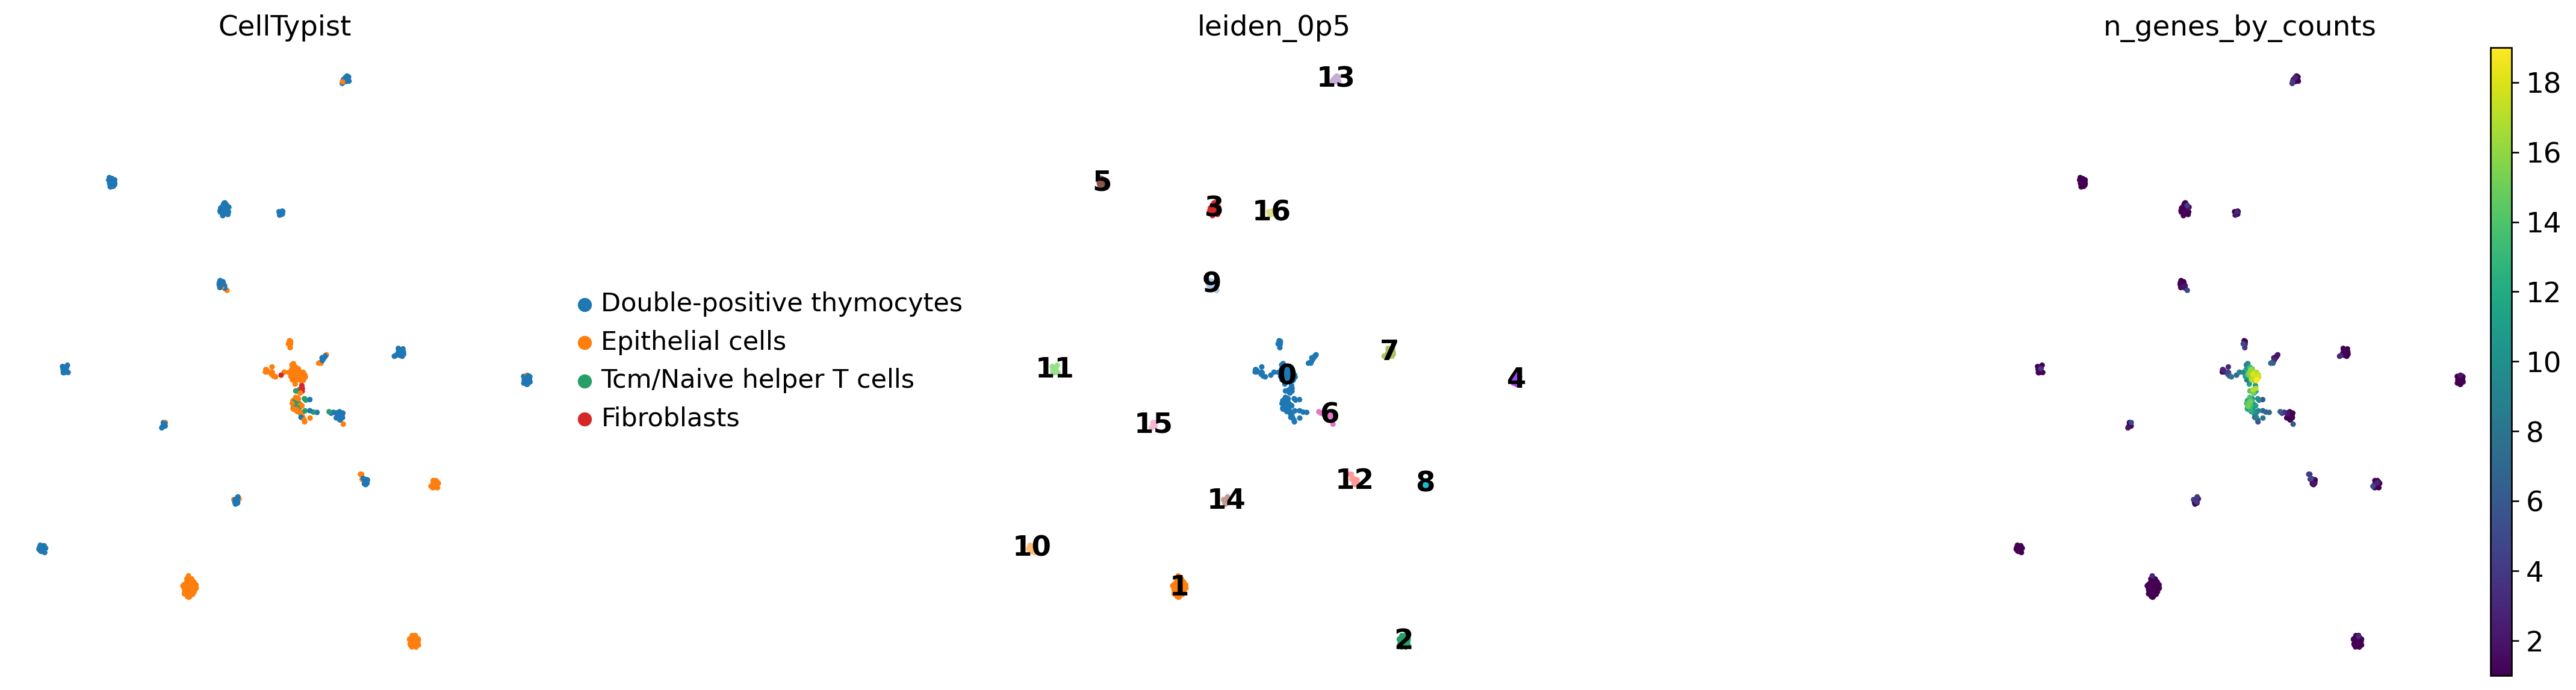

In [76]:
# Cell 7b


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc

assert "celltypist_label" in adata.obs, "Run CellTypist first (Cell 7)."

# Making sure labels are categorical (helps Scanpy pick a palette)
if not pd.api.types.is_categorical_dtype(adata.obs["celltypist_label"]):
    adata.obs["celltypist_label"] = pd.Categorical(adata.obs["celltypist_label"].astype(str))

# order label categories by size for a tidier legend
sizes = adata.obs["celltypist_label"].value_counts()
ordered = list(sizes.index.astype(str))
adata.obs["celltypist_label"] = adata.obs["celltypist_label"].cat.reorder_categories(ordered, ordered=True)

sc.set_figure_params(dpi=120)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# CellTypist labels with legend at right 
sc.pl.umap(
    adata,
    color="celltypist_label",
    legend_loc="right margin",
    frameon=False,
    size=30,          
    ax=axes[0],
    title="CellTypist",
    show=False,
)

# Leiden clusters (to compare with Cell 6's output)
sc.pl.umap(
    adata,
    color="leiden_0p5",
    legend_loc="on data",
    frameon=False,
    size=30,
    ax=axes[1],
    title="leiden_0p5",
    show=False,
)

# QC metric (matches the Cell 6 look)
sc.pl.umap(
    adata,
    color="n_genes_by_counts",   # or "total_counts"
    frameon=False,
    size=30,
    ax=axes[2],
    title="n_genes_by_counts",
    show=False,
)

plt.tight_layout()
fig.savefig(OUT / "week6_umap_celltypist_panel.png", bbox_inches="tight")
plt.show()



Estimated completion time is 6 hours.

# Finish this tomorrow. Need to make it so that the data files are unpacked through the notebook so that the files can be pushed and ran in CI on github.